In [2]:
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
base_dir = '/content/drive/My Drive/Capstone Project/Machine Learning/'
!ls '/content/drive/My Drive/Capstone Project/Machine Learning/'

data  train  validation


In [4]:
data_dir = os.path.join(base_dir, 'data')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
ktp_dir = os.path.join(data_dir, 'ktp/')
nonktp_dir = os.path.join(data_dir, 'nonktp/')

print(f"There are {len(os.listdir(ktp_dir))} images of ktp.")
print(f"There are {len(os.listdir(nonktp_dir))} images of nonktp.")

There are 148 images of ktp.
There are 78 images of nonktp.


In [6]:
train_ktp = os.path.join(train_dir, 'ktp/')
train_nonktp = os.path.join(train_dir, 'nonktp/')

In [7]:
validation_ktp = os.path.join(validation_dir, 'ktp/')
validation_nonktp = os.path.join(validation_dir, 'nonktp/')

In [8]:
import random
from shutil import copyfile

def train_val_split_data(source, train, val, split_size):
  files=[]
  for filename in os.listdir(source):
    file = source + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(f"{filename} is zero length, so ignoring") 

    train_length = int(len(files) * split_size)
    val_length = int(len(files) - train_length)
    shuffled_set = random.sample(files, len(files))
    train_set = shuffled_set[0:train_length]
    val_set = shuffled_set[-val_length:]

  for filename in train_set:
    src_file = source + filename
    dest_file = train + filename
    copyfile(src_file, dest_file)
    
  for filename in val_set:
    src_file = source + filename
    dest_file = val + filename
    copyfile(src_file, dest_file)

In [9]:
split_size = .75

train_val_split_data(ktp_dir, train_ktp, validation_ktp, split_size)
train_val_split_data(nonktp_dir, train_nonktp, validation_nonktp, split_size)

print(f"\n\nThere are {len(os.listdir(train_ktp))} images of ktp for training")
print(f"There are {len(os.listdir(train_nonktp))} images of nonktp for training")
print(f"There are {len(os.listdir(validation_ktp))} images of ktp for testing")
print(f"There are {len(os.listdir(validation_nonktp))} images of nonktp for testing")



There are 111 images of ktp for training
There are 58 images of nonktp for training
There are 37 images of ktp for testing
There are 20 images of nonktp for testing


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [11]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.3,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   )

val_datagen = ImageDataGenerator(rescale=1./255
                                )

In [12]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    batch_size = 10,
                                                    class_mode = "binary",
                                                    target_size = (204, 324)
                                                    )

validation_generator = val_datagen.flow_from_directory(directory = validation_dir,
                                                  batch_size = 10,
                                                  class_mode = "binary",
                                                  target_size = (204, 324)
                                                  )

Found 169 images belonging to 2 classes.
Found 57 images belonging to 2 classes.


In [13]:
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape=(204,324,3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = 'relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
      ])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 202, 322, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 101, 161, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 99, 159, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 79, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 77, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 38, 64)       0

In [15]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy']) 

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

file_path = '/content/drive/My Drive/Capstone Project/'
checkpoint = ModelCheckpoint(file_path,
                             save_weight_only = True,
                             save_best_only = True,
                             monitor = 'val_accurancy',
                             mode = 'max')

In [25]:
history = model.fit(train_generator, 
                    steps_per_epoch = 16, 
                    epochs = 30, 
                    validation_data = validation_generator, 
                    validation_steps = 5, 
                    verbose = 2)

Epoch 1/30
16/16 - 16s - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.1349 - val_accuracy: 0.9200 - 16s/epoch - 995ms/step
Epoch 2/30
16/16 - 16s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1610 - val_accuracy: 0.9400 - 16s/epoch - 990ms/step
Epoch 3/30
16/16 - 16s - loss: 0.0215 - accuracy: 0.9874 - val_loss: 0.0405 - val_accuracy: 0.9800 - 16s/epoch - 986ms/step
Epoch 4/30
16/16 - 16s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.9800 - 16s/epoch - 981ms/step
Epoch 5/30
16/16 - 16s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0894 - val_accuracy: 0.9800 - 16s/epoch - 985ms/step
Epoch 6/30
16/16 - 16s - loss: 0.0122 - accuracy: 0.9937 - val_loss: 0.1854 - val_accuracy: 0.9600 - 16s/epoch - 984ms/step
Epoch 7/30
16/16 - 16s - loss: 0.0127 - accuracy: 0.9937 - val_loss: 0.0015 - val_accuracy: 1.0000 - 16s/epoch - 984ms/step
Epoch 8/30
16/16 - 16s - loss: 0.1469 - accuracy: 0.9811 - val_loss: 0.2197 - val_accuracy: 0.9400 - 16s/epoch - 987ms/step
Epoch 9/

Saving test1.jpg to test1 (2).jpg
test1.jpg
ktp


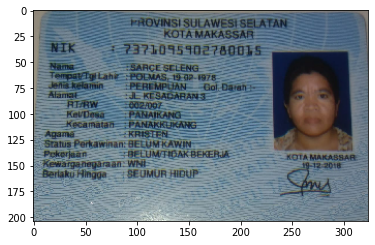

In [34]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (204, 324))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)
  print(fn)

  if classes==0:
   print('ktp')
  else:
   print('nonktp')

In [28]:
saved_model_path = "/content/drive/My Drive/Capstone Project/model.h5"
model.save(saved_model_path)